<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S5_AssignmentSolution4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the required libraries

from __future__ import print_function
import torch # PyTorch Main Library
import torch.nn as nn # Neural Net Lib
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt

In [22]:
# Model 7


class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()


     # Conv Block1
      self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10)) # output_size = 26
            

    # Conv Block2 
      self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels = 10, out_channels = 12, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(12)) # output_size = 24  



    # Conv Block3
      self.convblock3 = nn.Sequential(
          nn.Conv2d(in_channels = 12, out_channels = 12, kernel_size=(3,3), padding=0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(12)) # output_size = 22


    # TRANSITION BLOCK 1
      self.pool1 = nn.Sequential(nn.MaxPool2d(2, 2))# output_size = 11


    # Conv Block4
      self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels = 12, out_channels = 16, kernel_size = (1,1), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) # output_size = 11


    # Conv Block5
      self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (3,3), padding=0, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(16)) #output_size = 9


    # Conv Block6
      self.convblock6 = nn.Sequential(
          nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size=(3,3), padding = 0, bias=False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # output_size = 7

 
    # Conv Block7
      self.convblock7 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding = 0, bias = False),
          nn.ReLU(),
          nn.BatchNorm2d(16)) # output_size = 5


    # Conv Block8
      self.convblock8 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels=10, kernel_size =(1,1), padding =0, bias=False)) # output_size = 1
      


    # Output Block
      self.gap = nn.Sequential(nn.AvgPool2d(5)) # Global Average Pooling


    # DropOut Layer
      self.drop1 = nn.Sequential(nn.Dropout(0.07))


    def forward(self, x):
      x = self.convblock1(x)
      x = self.convblock2(x)
      x = self.convblock3(x)
      x = self.pool1(x)
      x = self.convblock4(x)
      x = self.convblock5(x)
      x = self.convblock6(x)
      x = self.drop1(x)
      x = self.convblock7(x)
      x = self.gap(x)
      x = self.convblock8(x)

    
      
      x = x.view(-1, 10)
      return F.log_softmax(x, dim=-1)


  
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 12, 24, 24]           1,080
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
            Conv2d-7           [-1, 12, 22, 22]           1,296
              ReLU-8           [-1, 12, 22, 22]               0
       BatchNorm2d-9           [-1, 12, 22, 22]              24
        MaxPool2d-10           [-1, 12, 11, 11]               0
           Conv2d-11           [-1, 16, 11, 11]             192
             ReLU-12           [-1, 16, 11, 11]               0
      BatchNorm2d-13           [-1, 16, 11, 11]              32
           Conv2d-14             [-1, 1

In [0]:
# Data Loading and Pre-Processing


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),                          
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


test_loader = torch.utils.data.DataLoader(

    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)





In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('EPOCH:{} \nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(epoch,
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
# Optimization and Testing
from torch.optim.lr_scheduler import StepLR


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = ReduceLROnPlateau(optimizer, 'min')
scheduler = StepLR(optimizer, step_size=7, gamma=0.3) # Consistent with 99.3% Accuracy

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=15)


for epoch in range(1, 16):
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

Loss=0.06976625323295593 Batch_id=468 Accuracy=90.03: 100%|██████████| 469/469 [00:14<00:00, 31.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:1 
Test set: Average loss: 0.0726, Accuracy: 9816/10000 (98.16%)



Loss=0.08874743431806564 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:2 
Test set: Average loss: 0.0499, Accuracy: 9863/10000 (98.63%)



Loss=0.04722431302070618 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:15<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:3 
Test set: Average loss: 0.0368, Accuracy: 9884/10000 (98.84%)



Loss=0.012479419820010662 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:4 
Test set: Average loss: 0.0314, Accuracy: 9899/10000 (98.99%)



Loss=0.0614815391600132 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:14<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:5 
Test set: Average loss: 0.0290, Accuracy: 9918/10000 (99.18%)



Loss=0.020722076296806335 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:6 
Test set: Average loss: 0.0241, Accuracy: 9931/10000 (99.31%)



Loss=0.023318424820899963 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:7 
Test set: Average loss: 0.0262, Accuracy: 9918/10000 (99.18%)



Loss=0.0038896549958735704 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 30.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:8 
Test set: Average loss: 0.0182, Accuracy: 9949/10000 (99.49%)



Loss=0.060826677829027176 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:9 
Test set: Average loss: 0.0191, Accuracy: 9947/10000 (99.47%)



Loss=0.018248870968818665 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:15<00:00, 30.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:10 
Test set: Average loss: 0.0177, Accuracy: 9948/10000 (99.48%)



Loss=0.09738404303789139 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 32.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:11 
Test set: Average loss: 0.0186, Accuracy: 9943/10000 (99.43%)



Loss=0.006476104259490967 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 31.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:12 
Test set: Average loss: 0.0178, Accuracy: 9948/10000 (99.48%)



Loss=0.0035260419826954603 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:15<00:00, 30.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:13 
Test set: Average loss: 0.0173, Accuracy: 9947/10000 (99.47%)



Loss=0.02084174193441868 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:15<00:00, 30.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:14 
Test set: Average loss: 0.0169, Accuracy: 9947/10000 (99.47%)



Loss=0.004946266766637564 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 31.87it/s]


EPOCH:15 
Test set: Average loss: 0.0156, Accuracy: 9951/10000 (99.51%)



Text(0.5, 1.0, 'Test Accuracy')

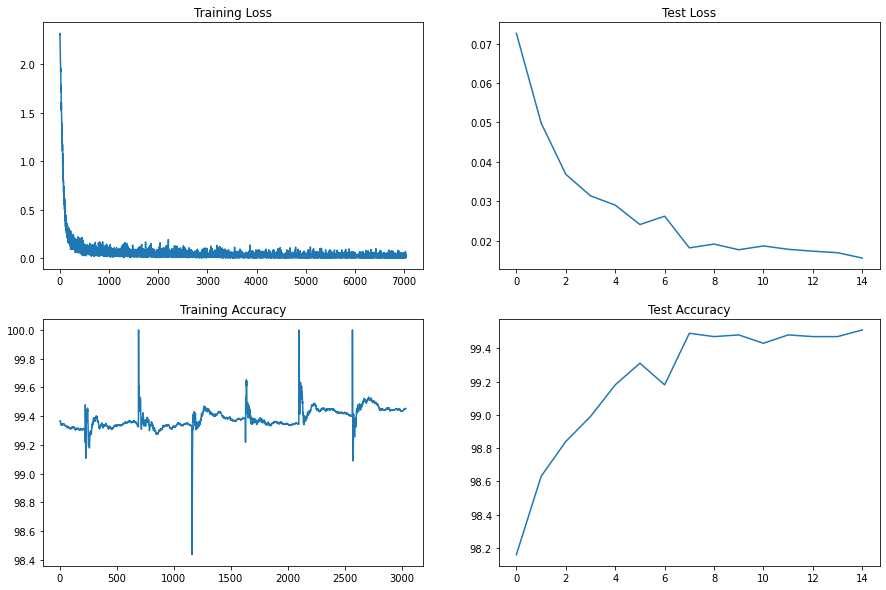

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")